In [1]:
# Last amended: 06th Nov, 2020
# Myfolder: C:\Users\Administrator\OneDrive\Documents\talkingdata
# Ref: https://www.kaggle.com/nanomathias/h2o-distributed-random-forest-starter
#      https://www.kdnuggets.com/2020/01/h2o-framework-machine-learning.html
#      Hyperparameter optimization using Bayes optimization
#      https://medium.com/spikelab/hyperparameter-optimization-using-bayesian-optimization-f1f393dcd36d
#
# Data source: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection
# Objectives:
#           i)   Ad-tracking fraud challenge
#           ii)  Learning to use bigdata
#           iii) Learn to work with h2o
#           iv)  Feature engineering
#                of categorical variables
#                using aggregation.
#            v)  Draw Learning curve
#            vi) Perform BayesOptimization
#

In [81]:
# 1.0 Call libraries
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os,time

In [ ]:
# 1.0.1 Modeling
from bayes_opt import BayesianOptimization
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [82]:
# 1.0.2 Display output from multiple commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [83]:
# 1.1 Change folder to where TalkingData is:
os.chdir("C:\\Users\\Administrator\\OneDrive\\Documents\\talkingdata")

In [84]:
# 1.2 Start h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 43 mins
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,5 months and 6 days !!!
H2O_cluster_name:,H2O_from_python_Administrator_rywcmf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.789 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [85]:
# 2.0 Read a fraction of data
#tr_f = "train.csv.zip"
tr_f = "out.csv.zip"
total_lines = 184903891
read_lines = 150000    # Reduce it if less RAM

In [10]:
# 2.1 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read


In [182]:
# 2.1.1 How to pick up random rows from hard-disk
#       without first loading the complete file in RAM
#       Toss a coin:
#           At each row, toss a biased-coin: 60%->Head, 40%->tail
#           If tail comes, select the row else not.
#           Toss a coin: random.random()
#           Head occurs if value > 0.6 else it is tail
#
#       We do not toss the coin for header row. Keep the header
start = time.time()
train = pd.read_csv(
                tr_f,
                header=0,   # First row is header-row
                            # 'and' operator returns True if both values are True
                            #  random.random() returns values between (0,1)
                            #  No of rows skipped will be around 60% of total
                #skiprows=lambda i: (i >0 ) and (np.random.random() > p)    # (i>0) implies skip first header row
                )
end = time.time()
(end-start)/60      # 4 minutes

0.03561946153640747

In [183]:
# 2.1.2 Store sampled data to a file for later use
train.to_csv("out.csv.zip", compression = "zip", index = False)

In [184]:
# 2.1.3
train.head()

# 2.1.4
train.dtypes    # ip int64,app int64,device int64,os int64,channel int64,
                # click_time object,attributed_time object,is_attributed int64

# 2.1.5 Let us see distribution of NULLS
train.isnull().sum()      # 299084 nulls in attributed_time

# 2.1.6
train.shape    # (299847, 8)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,135659,3,1,13,379,2017-11-06 15:40:59,NaN,0
1,44645,3,1,19,379,2017-11-06 15:47:29,NaN,0
2,84774,3,1,19,379,2017-11-06 15:47:52,NaN,0
3,72967,3,1,19,115,2017-11-06 16:00:02,NaN,0
4,65813,15,1,26,3,2017-11-06 16:00:02,NaN,0


ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

ip                      0
app                     0
device                  0
os                      0
channel                 0
click_time              0
attributed_time    149563
is_attributed           0
dtype: int64

(149936, 8)

In [185]:
# 2.2 Transform pandas DataFrame to H2OFrame
train_h2o_types = ['numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'time', 'time', 'numeric']
train_h2o = h2o.H2OFrame(train) #,column_types = train_h2o_types )

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [186]:
# 2.2 Transform pandas DataFrame to H2OFrame
train_h2o_types = ['numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'time', 'time', 'numeric']
train_h2o = h2o.H2OFrame(train) #,column_types = train_h2o_types )

# 2.3 Check
type(train_h2o)    # h2o.frame.H2OFrame

# 2.3.1
train_h2o.types    # {'ip': 'int','app': 'int','device': 'int','os': 'int',
                   # 'channel': 'int','click_time': 'time','attributed_time': 'time',
                   # 'is_attributed': 'int'}

Parse progress: |█████████████████████████████████████████████████████████| 100%


h2o.frame.H2OFrame

{'ip': 'int',
 'app': 'int',
 'device': 'int',
 'os': 'int',
 'channel': 'int',
 'click_time': 'time',
 'attributed_time': 'time',
 'is_attributed': 'int'}

In [187]:
# 2.4 Explore data:
#     Note that NaN in pandas are replaced
#     by empty spaces in the h2o frame display

train_h2o.head()

train_h2o.shape    # (299847, 8)


ip,app,device,os,channel,click_time,attributed_time,is_attributed
135659,3,1,13,379,2017-11-06 15:40:59,,0
44645,3,1,19,379,2017-11-06 15:47:29,,0
84774,3,1,19,379,2017-11-06 15:47:52,,0
72967,3,1,19,115,2017-11-06 16:00:02,,0
65813,15,1,26,3,2017-11-06 16:00:02,,0
29377,14,1,17,379,2017-11-06 16:00:03,,0
182690,12,1,9,265,2017-11-06 16:00:04,,0
47708,2,1,18,219,2017-11-06 16:00:05,,0
115568,23,1,32,153,2017-11-06 16:00:07,,0
98432,14,1,27,442,2017-11-06 16:00:07,,0


(149936, 8)

In [188]:
# 2.4.1 Check NAs
#       (Note: Without return_frame=True, one
#       gets total results.)
train_h2o.isna().sum(axis = 0, return_frame=True)

isNA(ip),isNA(app),isNA(device),isNA(os),isNA(channel),isNA(click_time),isNA(attributed_time),isNA(is_attributed)
0,0,0,0,0,0,149563,0


In [189]:
# 2.4.2 Check if data is balanced?
#       No. It is imbalanced data
train_h2o['is_attributed'].sum()    # 732.0
train_h2o['is_attributed'].mean()   # 0.002433599632965301

373.0

[0.002487728097321524]

In [190]:
# 3.0 We need to change some
#     columns to factor types

category_cols = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed']

In [191]:
# 3.1 The columns to be used during training

train_h2o.columns   # Existing columns

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'attributed_time',
 'is_attributed']

In [192]:
# 3.1.1 New columns (to be soon created) are:
#         'day', 'hour', 'qty1', 'qty2','qty3'
#          'qty1', 'qty2','qty3' are aggregated counts

X1 = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'qty1', 'qty2', 'qty3']
X2 = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'qty1', 'qty2']
X3 = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'qty1']

# 3.1.2 Target
y = 'is_attributed'

In [193]:
# 4.0 Transform some categorical columns to factors

for c in category_cols:
    if c in train.columns:
        train_h2o[c] = train_h2o[c].asfactor()

In [194]:
# 4.1 Factor columns become of type 'enum':

train_h2o.types      #  {'ip': 'enum','app': 'enum','device': 'enum',
                 #   'os': 'enum','channel': 'enum','click_time': 'time',
                 #   'attributed_time': 'time','is_attributed': 'enum'}

{'ip': 'enum',
 'app': 'enum',
 'device': 'enum',
 'os': 'enum',
 'channel': 'enum',
 'click_time': 'time',
 'attributed_time': 'time',
 'is_attributed': 'enum'}

In [195]:
# 4.2 Extract time data:

train_h2o['day']  = train_h2o['click_time'].day()
train_h2o['hour'] = train_h2o['click_time'].hour()

In [196]:
# 4.3 Let us now count how many times
#     the combination of values in
#     ['ip','day','hour'] occur together
#     Here are the steps:
# 4.3.1 (Not sure if the 'grouped' formation occurs)

grouped = train_h2o[['ip','day','hour']].group_by(by=['ip','day','hour'])
grouped.count()
grouped.count().get_frame()  # A new column by name of nrow is created

GroupBy: 
  Frame: py_143_sid_a604; by=[0, 1, 2]
  Aggregates: dict_keys(['nrow_ip'])
*** Use get_frame() to get groupby frame ***


ip,day,hour,nrow
6,8,12,1
9,7,8,1
9,9,4,1
9,9,8,1
9,9,15,1
10,6,22,1
19,7,1,1
20,6,23,1
20,7,0,2
20,8,4,1


In [197]:
# 4.3.2 (Better avoid 'grouped')
#       Aggregate categories

dx1 = train_h2o[['ip','day','hour']].group_by(by=['ip','day','hour']).count().get_frame()
dx2 = train_h2o[['ip','day']].group_by(by=['ip','day']).count().get_frame()
dx3 = train_h2o[['ip']].group_by(by=['ip']).count().get_frame()

In [198]:
# 4.3.3

dx1.shape      # (242488, 4)  (587680, 4)
dx2.shape      # (103459, 3)
dx3.shape      # (55477, 2)
dx1.head()
dx1.sort(by = 'nrow', ascending = False).head()

(130716, 4)

(71709, 3)

(42272, 2)

ip,day,hour,nrow
6,8,12,1
9,7,8,1
9,9,4,1
9,9,8,1
9,9,15,1
10,6,22,1
19,7,1,1
20,6,23,1
20,7,0,2
20,8,4,1


ip,day,hour,nrow
5348,9,13,43
5348,7,11,42
5348,7,12,42
5348,9,14,36
5314,7,13,35
5314,7,14,34
5314,8,13,32
5314,9,13,32
5348,7,13,32
5314,7,15,31


In [199]:
# 4.4 Check column-names:

dx1.columns
dx2.columns
dx3.columns

train_h2o.columns # ['ip','app','device','os','channel','click_time',
                  #  'attributed_time','is_attributed','day','hour']

['ip', 'day', 'hour', 'nrow']

['ip', 'day', 'nrow']

['ip', 'nrow']

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'attributed_time',
 'is_attributed',
 'day',
 'hour']

In [200]:
# 5.0 Merge this aggregated data with
#     main dataset. That is merge: train and dx

df_h2o = train_h2o.merge(                          # train is designated as 'x':
                     dx1,
                     all_x = True,              # So all of train. Left join
                     by_x=['ip','day','hour'],  # Key-columns from left-hand side
                     by_y=['ip','day','hour']   # Key-columns from right-hand side
                    )

In [201]:
# 5.1 Rename column 'nrow' to 'qty1'

df_h2o = df_h2o.rename({'nrow': 'qty1'})

In [202]:
# 5.2 To this df_h2o, we add more columns.
#     Merge to this dataframe, dx2

df_h2o = df_h2o.merge(
                     dx2,
                     all_x = True,
                     by_x=['ip','day'],
                     by_y=['ip','day']
                    )

# 5.2.1 And rename 'nrow' column to 'qty2'

df_h2o = df_h2o.rename({'nrow': 'qty2'})

In [203]:
# 5.3 More merger
df_h2o = df_h2o.merge(
                     dx3,
                     all_x = True,
                     by_x=['ip'],
                     by_y=['ip']
                    )

# 5.3.1
df_h2o = df_h2o.rename({'nrow': 'qty3'})

In [204]:
range1 = df_h2o['qty1'].max() - df_h2o['qty1'].min()
range2 = df_h2o['qty2'].max() - df_h2o['qty2'].min()
range3 = df_h2o['qty3'].max() - df_h2o['qty3'].min()


In [205]:
# 5.4 Normalize columns: qty1, qty2, qty3

#df_h2o['qty1'] = (df_h2o['qty1'] - df_h2o['qty1'].min())/range1
#df_h2o['qty2'] = (df_h2o['qty2'] - df_h2o['qty2'].min())/range2
#df_h2o['qty3'] = (df_h2o['qty3'] - df_h2o['qty3'].min())/range3

In [206]:
# 5.4.1

df_h2o.shape     # (299705, 13)  (899323, 12)
df_h2o.columns   # ['ip','hour','day','app','device','os',
                 #  'channel','click_time','attributed_time',
                 # 'is_attributed','qty1']

# 5.4.2 Just have a look at resulting DataFrame
df_h2o.sort(by = 'qty1', ascending= False).head(4)
df_h2o.sort(by = 'qty1', ascending= False).tail(4)

(149936, 13)

['ip',
 'day',
 'hour',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'attributed_time',
 'is_attributed',
 'qty1',
 'qty2',
 'qty3']

ip,day,hour,app,device,os,channel,click_time,attributed_time,is_attributed,qty1,qty2,qty3
5348,9,13,9,2,37,442,2017-11-09 13:01:11,,0,43,290,990
5348,9,13,3,1,10,480,2017-11-09 13:01:40,,0,43,290,990
5348,9,13,15,1,13,480,2017-11-09 13:01:55,,0,43,290,990
5348,9,13,9,1,2,215,2017-11-09 13:04:00,,0,43,290,990


ip,day,hour,app,device,os,channel,click_time,attributed_time,is_attributed,qty1,qty2,qty3
364712,9,15,9,1,14,232,2017-11-09 15:36:50,,0,1,1,1
364715,9,0,12,1,13,497,2017-11-09 00:36:51,,0,1,1,1
364758,9,12,151,0,24,347,2017-11-09 12:36:29,,0,1,1,1
364776,9,12,14,1,22,113,2017-11-09 12:01:37,,0,1,1,1


In [207]:
# 5.5 Split df_h2o dataframe in ratio of 70:30
train, test = df_h2o.split_frame(ratios=[0.7])

In [208]:
#######################
#   MODEL TRAINING    #
#######################
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html#defining-a-drf-model
# Balance Classes:
#   # http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/balance_classes.html


# 6.0 Create classifier, balance classes
clf = H2ORandomForestEstimator(
                                ntrees = 200,         # Default 50
                                balance_classes=True, # Default False
                                validation_frame = test,
                                nfolds = 3,
                                score_each_iteration = True # Default = False
                               )

In [167]:
# 6.1 Create classifier, do not balance classes:

clf1 = H2ORandomForestEstimator(
                                 ntrees = 200,
                                 balance_classes=False,
                                 validation_frame = test,
                                 nfolds = 3
                                )

In [ ]:
# 6.2 Want to know more about H2ORandomForestEstimator?
#     Here is help
help(clf)

In [209]:
# 7.0 Train classifier: Ist
start = time.time()
clf.train(
          X1, y,      # Can try with X2 or X3 also
          training_frame = train
          )
end = time.time()
(end-start)/60          # 1.28 minutes

drf Model Build progress: |███████████████████████████████████████████████| 100%


6.375310568014781

In [169]:
# 7.1 Train classifier: IInd
start = time.time()
clf1.train(
           X1, y,
           training_frame = train
           )
end= time.time()
(end-start)/60

drf Model Build progress: |███████████████████████████████████████████████| 100%


1.0759214123090108

## Model performance

In [210]:
# 7.2 Check model performance. Ist model:
clf.model_performance()
clf.cross_validation_metrics_summary


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.09620218330709672
RMSE: 0.3101647679977478
LogLoss: 0.27479530162128357
Mean Per-Class Error: 5.727978310055004e-05
AUC: 0.9999952398085105
AUCPR: 0.9999935432842751
Gini: 0.9999904796170209

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08582851146667148: 


,,0,1,Error,Rate
0,0,104737.0,12.0,0.0001,(12.0/104749.0)
1,1,0.0,104750.0,0.0,(0.0/104750.0)
2,Total,104737.0,104762.0,0.0001,(12.0/209499.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.085829,0.999943,392.0
1,max f2,0.085829,0.999977,392.0
2,max f0point5,0.096136,0.999912,391.0
3,max accuracy,0.085829,0.999943,392.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.085829,1.000000,392.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.085829,0.999885,392.0
8,max min_per_class_accuracy,0.085829,0.999885,392.0
9,max mean_per_class_accuracy,0.085829,0.999943,392.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.967559,1.999990,1.999990,1.000000,0.977614,1.000000,0.977614,0.020000,0.020000,99.999045,99.999045
1,,2,0.020000,0.955745,1.999990,1.999990,1.000000,0.961365,1.000000,0.969489,0.020000,0.040000,99.999045,99.999045
2,,3,0.030000,0.946040,1.999990,1.999990,1.000000,0.950802,1.000000,0.963260,0.020000,0.060000,99.999045,99.999045
3,,4,0.040000,0.936850,1.999990,1.999990,1.000000,0.941433,1.000000,0.957804,0.020000,0.080000,99.999045,99.999045
4,,5,0.050000,0.926858,1.999990,1.999990,1.000000,0.931942,1.000000,0.952631,0.020000,0.100000,99.999045,99.999045
5,,6,0.100000,0.872270,1.999990,1.999990,1.000000,0.899890,1.000000,0.926261,0.100000,0.200000,99.999045,99.999045
6,,7,0.150001,0.815353,1.999990,1.999990,1.000000,0.843059,1.000000,0.898527,0.100000,0.300000,99.999045,99.999045
7,,8,0.200001,0.765590,1.999990,1.999990,1.000000,0.790588,1.000000,0.871542,0.100000,0.400000,99.999045,99.999045
8,,9,0.300001,0.559135,1.999895,1.999959,0.999952,0.683658,0.999984,0.808914,0.199990,0.599990,99.989499,99.995863
9,,10,0.400002,0.372833,1.999990,1.999967,1.000000,0.464172,0.999988,0.722729,0.200000,0.799990,99.999045,99.996659


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1604756492679_34734


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,200.0,200.0,1036392.0,20.0,20.0,20.0,205.0,323.0,259.945




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.09620218330709672
RMSE: 0.3101647679977478
LogLoss: 0.27479530162128357
Mean Per-Class Error: 5.727978310055004e-05
AUC: 0.9999952398085105
AUCPR: 0.9999935432842751
Gini: 0.9999904796170209

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08582851146667148: 


,,0,1,Error,Rate
0,0,104737.0,12.0,0.0001,(12.0/104749.0)
1,1,0.0,104750.0,0.0,(0.0/104750.0)
2,Total,104737.0,104762.0,0.0001,(12.0/209499.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.085829,0.999943,392.0
1,max f2,0.085829,0.999977,392.0
2,max f0point5,0.096136,0.999912,391.0
3,max accuracy,0.085829,0.999943,392.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.085829,1.000000,392.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.085829,0.999885,392.0
8,max min_per_class_accuracy,0.085829,0.999885,392.0
9,max mean_per_class_accuracy,0.085829,0.999943,392.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.967559,1.999990,1.999990,1.000000,0.977614,1.000000,0.977614,0.020000,0.020000,99.999045,99.999045
1,,2,0.020000,0.955745,1.999990,1.999990,1.000000,0.961365,1.000000,0.969489,0.020000,0.040000,99.999045,99.999045
2,,3,0.030000,0.946040,1.999990,1.999990,1.000000,0.950802,1.000000,0.963260,0.020000,0.060000,99.999045,99.999045
3,,4,0.040000,0.936850,1.999990,1.999990,1.000000,0.941433,1.000000,0.957804,0.020000,0.080000,99.999045,99.999045
4,,5,0.050000,0.926858,1.999990,1.999990,1.000000,0.931942,1.000000,0.952631,0.020000,0.100000,99.999045,99.999045
5,,6,0.100000,0.872270,1.999990,1.999990,1.000000,0.899890,1.000000,0.926261,0.100000,0.200000,99.999045,99.999045
6,,7,0.150001,0.815353,1.999990,1.999990,1.000000,0.843059,1.000000,0.898527,0.100000,0.300000,99.999045,99.999045
7,,8,0.200001,0.765590,1.999990,1.999990,1.000000,0.790588,1.000000,0.871542,0.100000,0.400000,99.999045,99.999045
8,,9,0.300001,0.559135,1.999895,1.999959,0.999952,0.683658,0.999984,0.808914,0.199990,0.599990,99.989499,99.995863
9,,10,0.400002,0.372833,1.999990,1.999967,1.000000,0.464172,0.999988,0.722729,0.200000,0.799990,99.999045,99.996659




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.002195235408768678
RMSE: 0.04685333935557505
LogLoss: 0.026635782507756403
Mean Per-Class Error: 0.13080939512227674
AUC: 0.8823937214488711
AUCPR: 0.35686096172480125
Gini: 0.7647874428977421

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.003992088854519719: 


,,0,1,Error,Rate
0,0,44749.0,65.0,0.0015,(65.0/44814.0)
1,1,57.0,46.0,0.5534,(57.0/103.0)
2,Total,44806.0,111.0,0.0027,(122.0/44917.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.003992,0.429907,110.0
1,max f2,0.000508,0.501374,261.0
2,max f0point5,0.023906,0.478088,36.0
3,max accuracy,0.023906,0.997952,36.0
4,max precision,0.332056,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.332056,1.000000,0.0
7,max absolute_mcc,0.003992,0.428848,110.0
8,max min_per_class_accuracy,0.000011,0.786408,395.0
9,max mean_per_class_accuracy,0.000066,0.869191,361.0



Gains/Lift Table: Avg response rate:  0.23 %, avg score:  0.01 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010018,0.000223,72.681230,72.681230,0.166667,8.720367e-03,0.166667,0.008720,0.728155,0.728155,7168.122977,7168.122977
1,,2,0.020015,0.000066,1.942483,37.351199,0.004454,1.195397e-04,0.085651,0.004425,0.019417,0.747573,94.248276,3635.119928
2,,3,0.030011,0.000037,0.971241,25.233543,0.002227,4.868925e-05,0.057864,0.002967,0.009709,0.757282,-2.875862,2423.354268
3,,4,0.040029,0.000023,0.969083,19.160680,0.002222,2.711045e-05,0.043938,0.002231,0.009709,0.766990,-3.091694,1816.068015
4,,5,0.053142,0.000013,0.740386,14.615413,0.001698,1.505908e-05,0.033515,0.001684,0.009709,0.776699,-25.961396,1361.541277
5,,6,1.000000,0.000000,0.235834,1.000000,0.000541,2.314183e-07,0.002293,0.000090,0.223301,1.000000,-76.416624,0.000000




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.002480420080361072
RMSE: 0.049803815921684876
LogLoss: 0.026049920675096074
Mean Per-Class Error: 0.10959933145300071
AUC: 0.9163783407461151
AUCPR: 0.37562347439909777
Gini: 0.8327566814922303

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.002739349270620696: 


,,0,1,Error,Rate
0,0,104592.0,157.0,0.0015,(157.0/104749.0)
1,1,142.0,128.0,0.5259,(142.0/270.0)
2,Total,104734.0,285.0,0.0028,(299.0/105019.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.002739,0.461261,214.0
1,max f2,0.001639,0.498305,252.0
2,max f0point5,0.007145,0.500000,139.0
3,max accuracy,0.012341,0.997686,95.0
4,max precision,0.990358,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.990358,1.000000,0.0
7,max absolute_mcc,0.002739,0.460004,214.0
8,max min_per_class_accuracy,0.000004,0.855556,397.0
9,max mean_per_class_accuracy,0.000040,0.890401,380.0



Gains/Lift Table: Avg response rate:  0.26 %, avg score:  0.01 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010008,0.000214,71.056306,71.056306,0.182683,8.778214e-03,0.182683,0.008778,0.711111,0.711111,7005.630616,7005.630616
1,,2,0.020006,0.000054,8.520060,39.803066,0.021905,1.052867e-04,0.102332,0.004444,0.085185,0.796296,752.005996,3880.306556
2,,3,0.030680,0.000026,0.693951,26.196201,0.001784,3.812277e-05,0.067349,0.002911,0.007407,0.803704,-30.604949,2519.620089
3,,4,0.043097,0.000013,0.596563,18.820609,0.001534,1.947478e-05,0.048387,0.002078,0.007407,0.811111,-40.343672,1782.060932
4,,5,0.051810,0.000012,1.275276,15.870052,0.003279,1.278728e-05,0.040801,0.001731,0.011111,0.822222,27.527626,1487.005248
5,,6,1.000000,0.000000,0.187492,1.000000,0.000482,2.628492e-07,0.002571,0.000090,0.177778,1.000000,-81.250834,0.000000




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,accuracy,0.9970768,3.7216212E-4,0.99720776,0.99665684,0.9973658
1,auc,0.9160554,0.021439016,0.9399025,0.898377,0.9098868
2,aucpr,0.39120626,0.09949731,0.4232023,0.27964723,0.47076926
3,err,0.0029232071,3.7216212E-4,0.0027922615,0.0033431437,0.002634216
4,err_count,102.333336,13.051181,98.0,117.0,92.0
5,f0point5,0.45173997,0.084269024,0.47188756,0.3592233,0.524109
6,f1,0.4659504,0.06976887,0.48958334,0.38743454,0.5208333
7,f2,0.48223695,0.053691555,0.508658,0.42045453,0.51759833
8,lift_top_group,70.75403,7.0613737,75.549095,62.645233,74.06775
9,logloss,0.026055248,0.0032464515,0.022549614,0.026658135,0.028957997



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-08 13:05:11,4 min 28.122 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-08 13:05:11,4 min 28.269 sec,1.0,0.230588,0.176120,0.998844,0.997710,1.995497,0.001809,0.055464,0.099893,0.682868,0.121027,1.000000,0.003206
2,,2020-11-08 13:05:11,4 min 28.369 sec,2.0,0.235160,0.173049,0.999049,0.998175,1.996535,0.001625,0.044499,0.051336,0.745497,0.261531,1.000000,0.002026
3,,2020-11-08 13:05:11,4 min 28.454 sec,3.0,0.258244,0.197830,0.999193,0.998466,1.997102,0.001410,0.043476,0.041226,0.774131,0.309965,1.000000,0.002516
4,,2020-11-08 13:05:11,4 min 28.554 sec,4.0,0.268581,0.209729,0.999313,0.998715,1.997621,0.001243,0.043256,0.037415,0.803073,0.321240,59.725011,0.002293
5,,2020-11-08 13:05:12,4 min 28.670 sec,5.0,0.266951,0.204460,0.999438,0.998943,1.998007,0.001050,0.044318,0.037260,0.807897,0.309534,61.071318,0.002093
6,,2020-11-08 13:05:12,4 min 28.786 sec,6.0,0.272945,0.210672,0.999513,0.999094,1.998312,0.000903,0.044295,0.036509,0.807738,0.328818,61.071318,0.002004
7,,2020-11-08 13:05:12,4 min 28.924 sec,7.0,0.270817,0.206546,0.999586,0.999227,1.998554,0.000748,0.044912,0.036775,0.807600,0.321180,62.021316,0.002427
8,,2020-11-08 13:05:12,4 min 29.055 sec,8.0,0.280695,0.220970,0.999640,0.999340,1.998789,0.000670,0.045080,0.035796,0.816683,0.314963,61.746885,0.002249
9,,2020-11-08 13:05:12,4 min 29.202 sec,9.0,0.278057,0.216151,0.999704,0.999467,1.999049,0.000557,0.045298,0.034081,0.831193,0.331172,62.165648,0.002427



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,channel,3.303296e+06,1.000000,0.387947
1,app,3.182384e+06,0.963397,0.373747
2,os,8.921641e+05,0.270083,0.104778
3,qty3,3.294594e+05,0.099737,0.038692
4,ip,3.069739e+05,0.092930,0.036052
5,device,2.217030e+05,0.067116,0.026037
6,hour,1.228316e+05,0.037185,0.014426
7,qty2,7.895117e+04,0.023901,0.009272
8,day,5.623264e+04,0.017023,0.006604
9,qty1,2.082225e+04,0.006303,0.002445


<bound method ModelBase.cross_validation_metrics_summary of >

In [43]:
# 7.3 Model performance: IInd model
clf1.model_performance()
clf1.cross_validation_metrics_summary


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.0015608380787427891
RMSE: 0.03950744333341236
LogLoss: 0.009718804712755547
Mean Per-Class Error: 0.08691298235914302
AUC: 0.9270989414309431
AUCPR: 0.5407660983316915
Gini: 0.8541978828618861

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21960444486167977: 


,,0,1,Error,Rate
0,0,104465.0,161.0,0.0015,(161.0/104626.0)
1,1,99.0,161.0,0.3808,(99.0/260.0)
2,Total,104564.0,322.0,0.0025,(260.0/104886.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219604,0.553265,184.0
1,max f2,0.183514,0.592151,205.0
2,max f0point5,0.463810,0.606618,97.0
3,max accuracy,0.567478,0.998084,72.0
4,max precision,0.991026,1.000000,0.0
5,max recall,0.000004,1.000000,399.0
6,max specificity,0.991026,1.000000,0.0
7,max absolute_mcc,0.219604,0.555213,184.0
8,max min_per_class_accuracy,0.000060,0.876923,397.0
9,max mean_per_class_accuracy,0.014615,0.913087,357.0



Gains/Lift Table: Avg response rate:  0.25 %, avg score:  0.24 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010001,0.038090,80.758451,80.758451,0.200191,2.130775e-01,0.200191,0.213078,0.807692,0.807692,7975.845127,7975.845127
1,,2,0.020003,0.013705,3.461076,42.109764,0.008580,2.082524e-02,0.104385,0.116951,0.034615,0.842308,246.107648,4110.976388
2,,3,0.030004,0.001788,0.769128,28.329552,0.001907,8.959855e-03,0.070226,0.080954,0.007692,0.850000,-23.087189,2732.955195
3,,4,0.040005,0.000197,0.384564,21.343305,0.000953,7.119563e-04,0.052908,0.060894,0.003846,0.853846,-61.543595,2034.330498
4,,5,0.050007,0.000074,0.000000,17.074644,0.000000,1.074056e-04,0.042326,0.048736,0.000000,0.853846,-100.000000,1607.464398
5,,6,0.100004,0.000025,0.461565,8.768896,0.001144,5.454064e-05,0.021737,0.024398,0.023077,0.876923,-53.843513,776.889635
6,,7,0.150010,0.000014,0.000000,5.845745,0.000000,1.703752e-05,0.014491,0.016270,0.000000,0.876923,-100.000000,484.574513
7,,8,0.200170,0.000012,0.076679,4.400112,0.000190,1.300457e-05,0.010907,0.012197,0.003846,0.880769,-92.332110,340.011248
8,,9,0.300622,0.000010,0.191443,2.993797,0.000475,1.085579e-05,0.007421,0.008125,0.019231,0.900000,-80.855747,199.379658
9,,10,0.400292,0.000008,0.154355,2.286794,0.000383,8.964264e-06,0.005669,0.006104,0.015385,0.915385,-84.564466,128.679364


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1604756492679_1409


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,200.0,200.0,944727.0,17.0,20.0,19.565,151.0,284.0,226.545




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.0015608380787427891
RMSE: 0.03950744333341236
LogLoss: 0.009718804712755547
Mean Per-Class Error: 0.08691298235914302
AUC: 0.9270989414309431
AUCPR: 0.5407660983316915
Gini: 0.8541978828618861

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21960444486167977: 


,,0,1,Error,Rate
0,0,104465.0,161.0,0.0015,(161.0/104626.0)
1,1,99.0,161.0,0.3808,(99.0/260.0)
2,Total,104564.0,322.0,0.0025,(260.0/104886.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219604,0.553265,184.0
1,max f2,0.183514,0.592151,205.0
2,max f0point5,0.463810,0.606618,97.0
3,max accuracy,0.567478,0.998084,72.0
4,max precision,0.991026,1.000000,0.0
5,max recall,0.000004,1.000000,399.0
6,max specificity,0.991026,1.000000,0.0
7,max absolute_mcc,0.219604,0.555213,184.0
8,max min_per_class_accuracy,0.000060,0.876923,397.0
9,max mean_per_class_accuracy,0.014615,0.913087,357.0



Gains/Lift Table: Avg response rate:  0.25 %, avg score:  0.24 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010001,0.038090,80.758451,80.758451,0.200191,2.130775e-01,0.200191,0.213078,0.807692,0.807692,7975.845127,7975.845127
1,,2,0.020003,0.013705,3.461076,42.109764,0.008580,2.082524e-02,0.104385,0.116951,0.034615,0.842308,246.107648,4110.976388
2,,3,0.030004,0.001788,0.769128,28.329552,0.001907,8.959855e-03,0.070226,0.080954,0.007692,0.850000,-23.087189,2732.955195
3,,4,0.040005,0.000197,0.384564,21.343305,0.000953,7.119563e-04,0.052908,0.060894,0.003846,0.853846,-61.543595,2034.330498
4,,5,0.050007,0.000074,0.000000,17.074644,0.000000,1.074056e-04,0.042326,0.048736,0.000000,0.853846,-100.000000,1607.464398
5,,6,0.100004,0.000025,0.461565,8.768896,0.001144,5.454064e-05,0.021737,0.024398,0.023077,0.876923,-53.843513,776.889635
6,,7,0.150010,0.000014,0.000000,5.845745,0.000000,1.703752e-05,0.014491,0.016270,0.000000,0.876923,-100.000000,484.574513
7,,8,0.200170,0.000012,0.076679,4.400112,0.000190,1.300457e-05,0.010907,0.012197,0.003846,0.880769,-92.332110,340.011248
8,,9,0.300622,0.000010,0.191443,2.993797,0.000475,1.085579e-05,0.007421,0.008125,0.019231,0.900000,-80.855747,199.379658
9,,10,0.400292,0.000008,0.154355,2.286794,0.000383,8.964264e-06,0.005669,0.006104,0.015385,0.915385,-84.564466,128.679364




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.001642670523336988
RMSE: 0.04052987198767087
LogLoss: 0.009534746684132461
Mean Per-Class Error: 0.08913783013194254
AUC: 0.9324055353206807
AUCPR: 0.49160786688045255
Gini: 0.8648110706413614

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3180929241826137: 


,,0,1,Error,Rate
0,0,104535.0,91.0,0.0009,(91.0/104626.0)
1,1,137.0,123.0,0.5269,(137.0/260.0)
2,Total,104672.0,214.0,0.0022,(228.0/104886.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.318093,0.518987,140.0
1,max f2,0.142807,0.571332,224.0
2,max f0point5,0.484882,0.582011,93.0
3,max accuracy,0.484882,0.998017,93.0
4,max precision,0.948459,1.000000,0.0
5,max recall,0.000002,1.000000,399.0
6,max specificity,0.948459,1.000000,0.0
7,max absolute_mcc,0.318093,0.520376,140.0
8,max min_per_class_accuracy,0.000327,0.869231,394.0
9,max mean_per_class_accuracy,0.000733,0.910862,391.0



Gains/Lift Table: Avg response rate:  0.25 %, avg score:  0.24 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010001,3.726566e-02,78.835631,78.835631,0.195424,2.046183e-01,0.195424,0.204618,0.788462,0.788462,7783.563100,7783.563100
1,,2,0.020003,1.000581e-02,4.614769,41.725200,0.011439,1.978016e-02,0.103432,0.112199,0.046154,0.834615,361.476864,4072.519982
2,,3,0.030004,5.004242e-03,0.769128,28.073176,0.001907,6.853478e-03,0.069590,0.077084,0.007692,0.842308,-23.087189,2707.317592
3,,4,0.040005,2.691870e-03,0.769128,21.247164,0.001907,4.879022e-03,0.052669,0.059033,0.007692,0.850000,-23.087189,2024.716397
4,,5,0.050026,3.125000e-04,1.919161,17.375670,0.004757,1.026281e-03,0.043072,0.047414,0.019231,0.869231,91.916124,1637.566961
5,,6,0.101386,2.119273e-05,0.299542,8.725199,0.000743,5.871738e-05,0.021629,0.023425,0.015385,0.884615,-70.045837,772.519929
6,,7,0.150163,8.144081e-06,0.157704,5.942259,0.000391,1.441280e-05,0.014730,0.015820,0.007692,0.892308,-84.229566,494.225934
7,,8,0.201161,4.522204e-06,0.377087,4.531382,0.000935,5.721365e-06,0.011233,0.011811,0.019231,0.911538,-62.291298,353.138173
8,,9,0.300870,2.721846e-06,0.038574,3.042464,0.000096,3.394638e-06,0.007542,0.007898,0.003846,0.915385,-96.142592,204.246382
9,,10,0.401417,2.132952e-06,0.038252,2.289966,0.000095,2.418711e-06,0.005677,0.005920,0.003846,0.919231,-96.174780,128.996600




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,accuracy,0.9978159,2.4255645E-4,0.99771345,0.9980929,0.99764144
1,auc,0.9355434,0.012046771,0.9216394,0.9428601,0.9421307
2,aucpr,0.48995692,0.024840318,0.46619958,0.5157544,0.48791674
3,err,0.0021840718,2.4255645E-4,0.0022865636,0.0019070932,0.0023585584
4,err_count,76.333336,8.144527,80.0,67.0,82.0
5,f0point5,0.56019807,0.04985069,0.53805774,0.61728394,0.5252525
6,f1,0.5365101,0.027311709,0.50617284,0.5442177,0.5591398
7,f2,0.5207249,0.066807225,0.47785547,0.486618,0.59770113
8,lift_top_group,79.58403,2.8559284,76.376114,80.525955,81.85002
9,logloss,0.009534553,0.0012810413,0.011009626,0.008701167,0.008892866



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-11-07 19:28:02,41.750 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-07 19:28:02,41.810 sec,1.0,0.057619,0.109636,0.666000,0.106563,1.000000,0.003213
2,,2020-11-07 19:28:02,41.860 sec,2.0,0.052081,0.086424,0.694930,0.169355,1.000000,0.002642
3,,2020-11-07 19:28:02,41.900 sec,3.0,0.050678,0.078111,0.715962,0.205406,1.000000,0.003037
4,,2020-11-07 19:28:02,41.960 sec,4.0,0.049721,0.070356,0.721018,0.212407,1.000000,0.003114
5,,2020-11-07 19:28:02,42.000 sec,5.0,0.049011,0.066191,0.731342,0.223216,1.000000,0.002928
6,,2020-11-07 19:28:02,42.070 sec,6.0,0.048523,0.063797,0.737002,0.235026,1.000000,0.002794
7,,2020-11-07 19:28:02,42.155 sec,7.0,0.047495,0.057180,0.764041,0.261937,1.000000,0.002709
8,,2020-11-07 19:28:02,42.235 sec,8.0,0.046350,0.051225,0.777642,0.291449,1.000000,0.002592
9,,2020-11-07 19:28:02,42.300 sec,9.0,0.045821,0.046083,0.799976,0.308323,1.000000,0.002811



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,app,7940.839355,1.000000,0.241731
1,ip,5882.414551,0.740780,0.179069
2,channel,5791.422363,0.729321,0.176299
3,os,4864.717285,0.612620,0.148089
4,hour,2741.357422,0.345223,0.083451
5,device,1913.916138,0.241022,0.058262
6,qty3,1536.590332,0.193505,0.046776
7,day,1023.523010,0.128894,0.031158
8,qty2,919.447388,0.115787,0.027989
9,qty1,235.731476,0.029686,0.007176


<bound method ModelBase.cross_validation_metrics_summary of >

## Learning Curve
How the model learns, ireration by iteration

In [213]:
# 8.0 Get scoring history, tree by tree
#     OR, iteration by iteration

score_table = clf.scoring_history()
type(score_table)       # pandas.core.frame.DataFrame
score_table.head(5)

# 8.1 List table columns
score_table.columns

pandas.core.frame.DataFrame

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-08 13:05:11,4 min 28.122 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-08 13:05:11,4 min 28.269 sec,1.0,0.230588,0.176120,0.998844,0.997710,1.995497,0.001809,0.055464,0.099893,0.682868,0.121027,1.000000,0.003206
2,,2020-11-08 13:05:11,4 min 28.369 sec,2.0,0.235160,0.173049,0.999049,0.998175,1.996535,0.001625,0.044499,0.051336,0.745497,0.261531,1.000000,0.002026
3,,2020-11-08 13:05:11,4 min 28.454 sec,3.0,0.258244,0.197830,0.999193,0.998466,1.997102,0.001410,0.043476,0.041226,0.774131,0.309965,1.000000,0.002516
4,,2020-11-08 13:05:11,4 min 28.554 sec,4.0,0.268581,0.209729,0.999313,0.998715,1.997621,0.001243,0.043256,0.037415,0.803073,0.321240,59.725011,0.002293


Index(['', 'timestamp', 'duration', 'number_of_trees', 'training_rmse',
       'training_logloss', 'training_auc', 'training_pr_auc', 'training_lift',
       'training_classification_error', 'validation_rmse',
       'validation_logloss', 'validation_auc', 'validation_pr_auc',
       'validation_lift', 'validation_classification_error'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

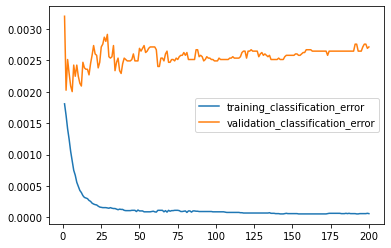

In [214]:
# 8.2 Plot learning curve
#     How the algorithm learns, iteration by iteration
fig = plt.figure()
abc = score_table[['training_classification_error','validation_classification_error']].plot() 

## Bayes optimization
Ref: [Hyperparameter Optimization using bayesian optimization](https://medium.com/spikelab/hyperparameter-optimization-using-bayesian-optimization-f1f393dcd36d)

In [215]:
# 9.0 First define an evaluation function

def train_eval_model(max_depth,ntrees,nbins_top_level,nbins_cats, sample_rate, col_sample_rate_per_tree):
    params = {
              'max_depth': int(max_depth),
              'ntrees'   : int(ntrees),
              'nbins_top_level': int(nbins_top_level),
              'nbins_cats'     :int(nbins_cats),
              'sample_rate'    :sample_rate,
              'col_sample_rate_per_tree':col_sample_rate_per_tree
            }
    model = H2ORandomForestEstimator(
                                    nfolds =3,
                                    **params
                                     )
    model.train(
                x=X1,
                y=y,
                training_frame=train
                )
    
    return model.auc()      # Should be -ve for loss as loss needs to be minimized

In [216]:
# 9.1 Next fit parameter bounds
param_bounds = {
         'max_depth':(5,10),
         'ntrees': (100,500),
         'nbins_top_level':(1000,1060),   # Default: 1024
         'nbins_cats':(1000,1060),        # Default: 1024
         'sample_rate':(0.5,1.0),
         'col_sample_rate_per_tree':(0.5,1.0)
         }

In [217]:
# 9.2 Create an instance of BayesOptimization class
optimizer = BayesianOptimization(
                                 f=train_eval_model,    # Function to evaluate
                                 pbounds=param_bounds,  # Within these parameter values
                                 random_state=1,
                                )


Finally we can get the best hyperparameters for our model

In [218]:
# 9.3 Start finding parameters that will maximize evaluation
optimizer.maximize(
                   init_points=10,   # Initial random points before 
                                     #   it starts applying its mind
                   n_iter=50         # This implies that total times
                                     #   model will be built: n_iter+init_points
                                     
                  )

|   iter    |  target   | col_sa... | max_depth | nbins_... | nbins_... |  ntrees   | sample... |
-------------------------------------------------------------------------------------------------
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  1        |  0.9612   |  0.7085   |  8.602    |  1e+03    |  1.018e+0 |  158.7    |  0.5462   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  2        |  0.9577   |  0.5931   |  6.728    |  1.024e+0 |  1.032e+0 |  267.7    |  0.8426   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  3        |  0.9512   |  0.6022   |  9.391    |  1.002e+0 |  1.04e+03 |  266.9    |  0.7793   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  4        |  0.9532   |  0.5702   |  5.991    |  1.048e+0 |  1.058e+0 |  225.4    |  0.8462   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  5   

|  45       |  0.9567   |  0.5666   |  5.549    |  1.023e+0 |  1.03e+03 |  269.4    |  0.693    |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  46       |  0.9559   |  0.6577   |  9.254    |  1.057e+0 |  1.033e+0 |  377.1    |  0.8201   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  47       |  0.9582   |  0.9551   |  9.882    |  1.052e+0 |  1.059e+0 |  441.5    |  0.6355   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  48       |  0.9488   |  0.9448   |  8.19     |  1.042e+0 |  1.044e+0 |  273.6    |  0.9288   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  49       |  0.9554   |  0.5773   |  7.521    |  1.001e+0 |  1.017e+0 |  162.5    |  0.8969   |
drf Model Build progress: |███████████████████████████████████████████████| 100%
|  50       |  0.9537   |  0.5994   |  8.798    |  1.001e+0 |  1.018e+0 |  159.9    |  0.6598   |
drf Mod

In [221]:
# 9.4 So for what parameter values we got maximum AUC
optimizer.max
# 9.4.1 Just check how to extract one of them
int(optimizer.max['params']['max_depth'])

{'target': 0.9611969954278712,
 'params': {'col_sample_rate_per_tree': 0.7085110023512871,
  'max_depth': 8.60162246721079,
  'nbins_cats': 1000.0068624890407,
  'nbins_top_level': 1018.1399543579104,
  'ntrees': 158.70235632684523,
  'sample_rate': 0.5461692973843989}}

8

In [222]:
# 10.0 Let use these parameters
#      Create classifier:
clf_bayes = H2ORandomForestEstimator(
                                      max_depth = int(optimizer.max['params']['max_depth']),
                                      ntrees = int(optimizer.max['params']['ntrees']),
                                      nbins_top_level =int(optimizer.max['params']['nbins_top_level']),
                                      nbins_cats = int(optimizer.max['params']['nbins_cats']),
                                      sample_rate = optimizer.max['params']['sample_rate'],
                                      col_sample_rate_per_tree =optimizer.max['params']['col_sample_rate_per_tree'],
                                      nfolds = 3,
                                      validation_frame = test,
                                      score_each_iteration = True
                                      )

In [223]:
# 10.1 Train classifier: IInd
start = time.time()
clf_bayes.train(
                X1, y,
                training_frame = train
               )
end= time.time()
(end-start)/60

drf Model Build progress: |███████████████████████████████████████████████| 100%


4.65485569636027

<Figure size 432x288 with 0 Axes>

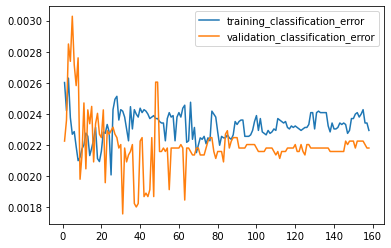

In [224]:
# 11.0 Get scoring history, tree by tree
#     (iteration-by-iteration) and plot
#      learning curve:

table_bayes = clf_bayes.scoring_history()
fig = plt.figure()
abc = table_bayes[['training_classification_error','validation_classification_error']].plot() 

In [225]:
######################################